In [77]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import random
import xlsxwriter
import math
import statistics
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as pl

In [45]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
x = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

data = pd.concat([x, y], axis=1)
data = data.rename(columns={"Y house price of unit area": "target"})

In [46]:
# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [47]:
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['target'] = y

In [48]:
# Initialize KNN classifier
knn = KNeighborsClassifier()
# Initialize KNN classifier with weights
knn_weight = KNeighborsClassifier(weights='distance')

# Initialize Decision Tree                                                               
dtree_entropy = DecisionTreeClassifier(criterion='entropy')

# Initialize Decision Tree
dtree_gini = DecisionTreeClassifier(criterion='gini')

In [50]:
#Prepare model
rf_g = {
    "name" : "Random Forest",
    "model" : RandomForestRegressor()
}

dt_g = {
    "name" : "Decision Tree",
    "model" : DecisionTreeRegressor()
}

knn_g = {
    "name" : "KNN",
    "model" : KNeighborsRegressor()
}

In [51]:
#Parameter:
# (DataFrame) dataframe - contains dataset
# (int) number_of_folds - number of division on the dataset

#Return: List of divided DataFrame

def slide_df_to_n_folds (data_frame, number_of_folds) :
    #--General function variables
    wrapper_array = []
    list_of_divided_dataframe = []
    
    #--Shuffle and divide the index of data_frame
    index_of_df = list(range(data_frame.shape[0]))
    random.shuffle(index_of_df)
    #Calculate the number of fold will be divided into
    number_of_element_per_fold = math.ceil(len(index_of_df)/number_of_folds)
    #Divide the list of array into the corresponding fold
    for k in range (0, len(index_of_df), number_of_element_per_fold):
        wrapper_array.append(index_of_df[k:k+number_of_element_per_fold])
    
    #--Divide the dataframe based on the index was created
    for m in range(len(wrapper_array)):
        new_dataframe = data_frame.iloc[wrapper_array[m]]
        list_of_divided_dataframe.append(new_dataframe)
        
    return list_of_divided_dataframe


In [52]:
def prepare_train_test_tuples (list_of_divided_dataframe):
    train_test_tuples = []
    for inx, fold in enumerate(list_of_divided_dataframe):
        train_df = list_of_divided_dataframe[inx]
        test_dfs = list_of_divided_dataframe[:inx] + list_of_divided_dataframe[inx+1:]
        test_df = pd.concat(test_dfs,axis=0)

        train_test_tuples.append((train_df, test_df))

    return train_test_tuples

In [96]:
#
def cross_validate(models, dataset ,fold_number = 5):

    #--Prepare data
    folds = slide_df_to_n_folds (dataset, fold_number)
    train_test_tuples = prepare_train_test_tuples(folds)
    truth_val_tests = []

    for train_test_tuple in train_test_tuples:
        truth_val_tests.append(train_test_tuple[1]["target"])

    model_predictions_tuples = []
    for model in models:
        predictions = []

        for train_test_tuple in train_test_tuples:
            train_data = train_test_tuple[0]
            test_data = train_test_tuple[1]

            #--Train model on training fold
            model["model"].fit(train_data.drop(columns='target'), train_data.target)
            #--Make prediction
            prediction_result = model["model"].predict(test_data.drop(columns='target'))

            predictions.append(prediction_result)

        model_predictions_tuples.append((model,predictions))

    return truth_val_tests, model_predictions_tuples

In [167]:
def plot_cv_results(truth_val_tests,model_predictions_tuples) :
    #Configure graph properties
    pl.rcParams['figure.figsize'] = [30, 20]
    #pl.rcParams["figure.autolayout"] = True

    #Define color line for different model
    model_color_dic = {
        "Random Forest" : "red",
        "Decision Tree" : "blue",
        "KNN": "yellow"
    }

    fig, ax = pl.subplots(len(truth_val_tests))

    for inx, truth_val_test in enumerate(truth_val_tests):
        # ax[inx].rcParams['figure.figsize'] = [30, 20]
        ax[inx].plot(truth_val_test.tolist(), linestyle="dotted", color="green",label= "Truth value")
        ax[inx].set_title(f"Fold number {inx}")
        ax[inx].legend(loc="upper right")

        for model_prediction_tuple in model_predictions_tuples:
            model_name = model_prediction_tuple[0]["name"]
            ax[inx].plot(model_prediction_tuple[1][inx], linestyle="dotted", color=f"{model_color_dic[model_name]}", label=model_name)
            ax[inx].legend(loc="upper right")


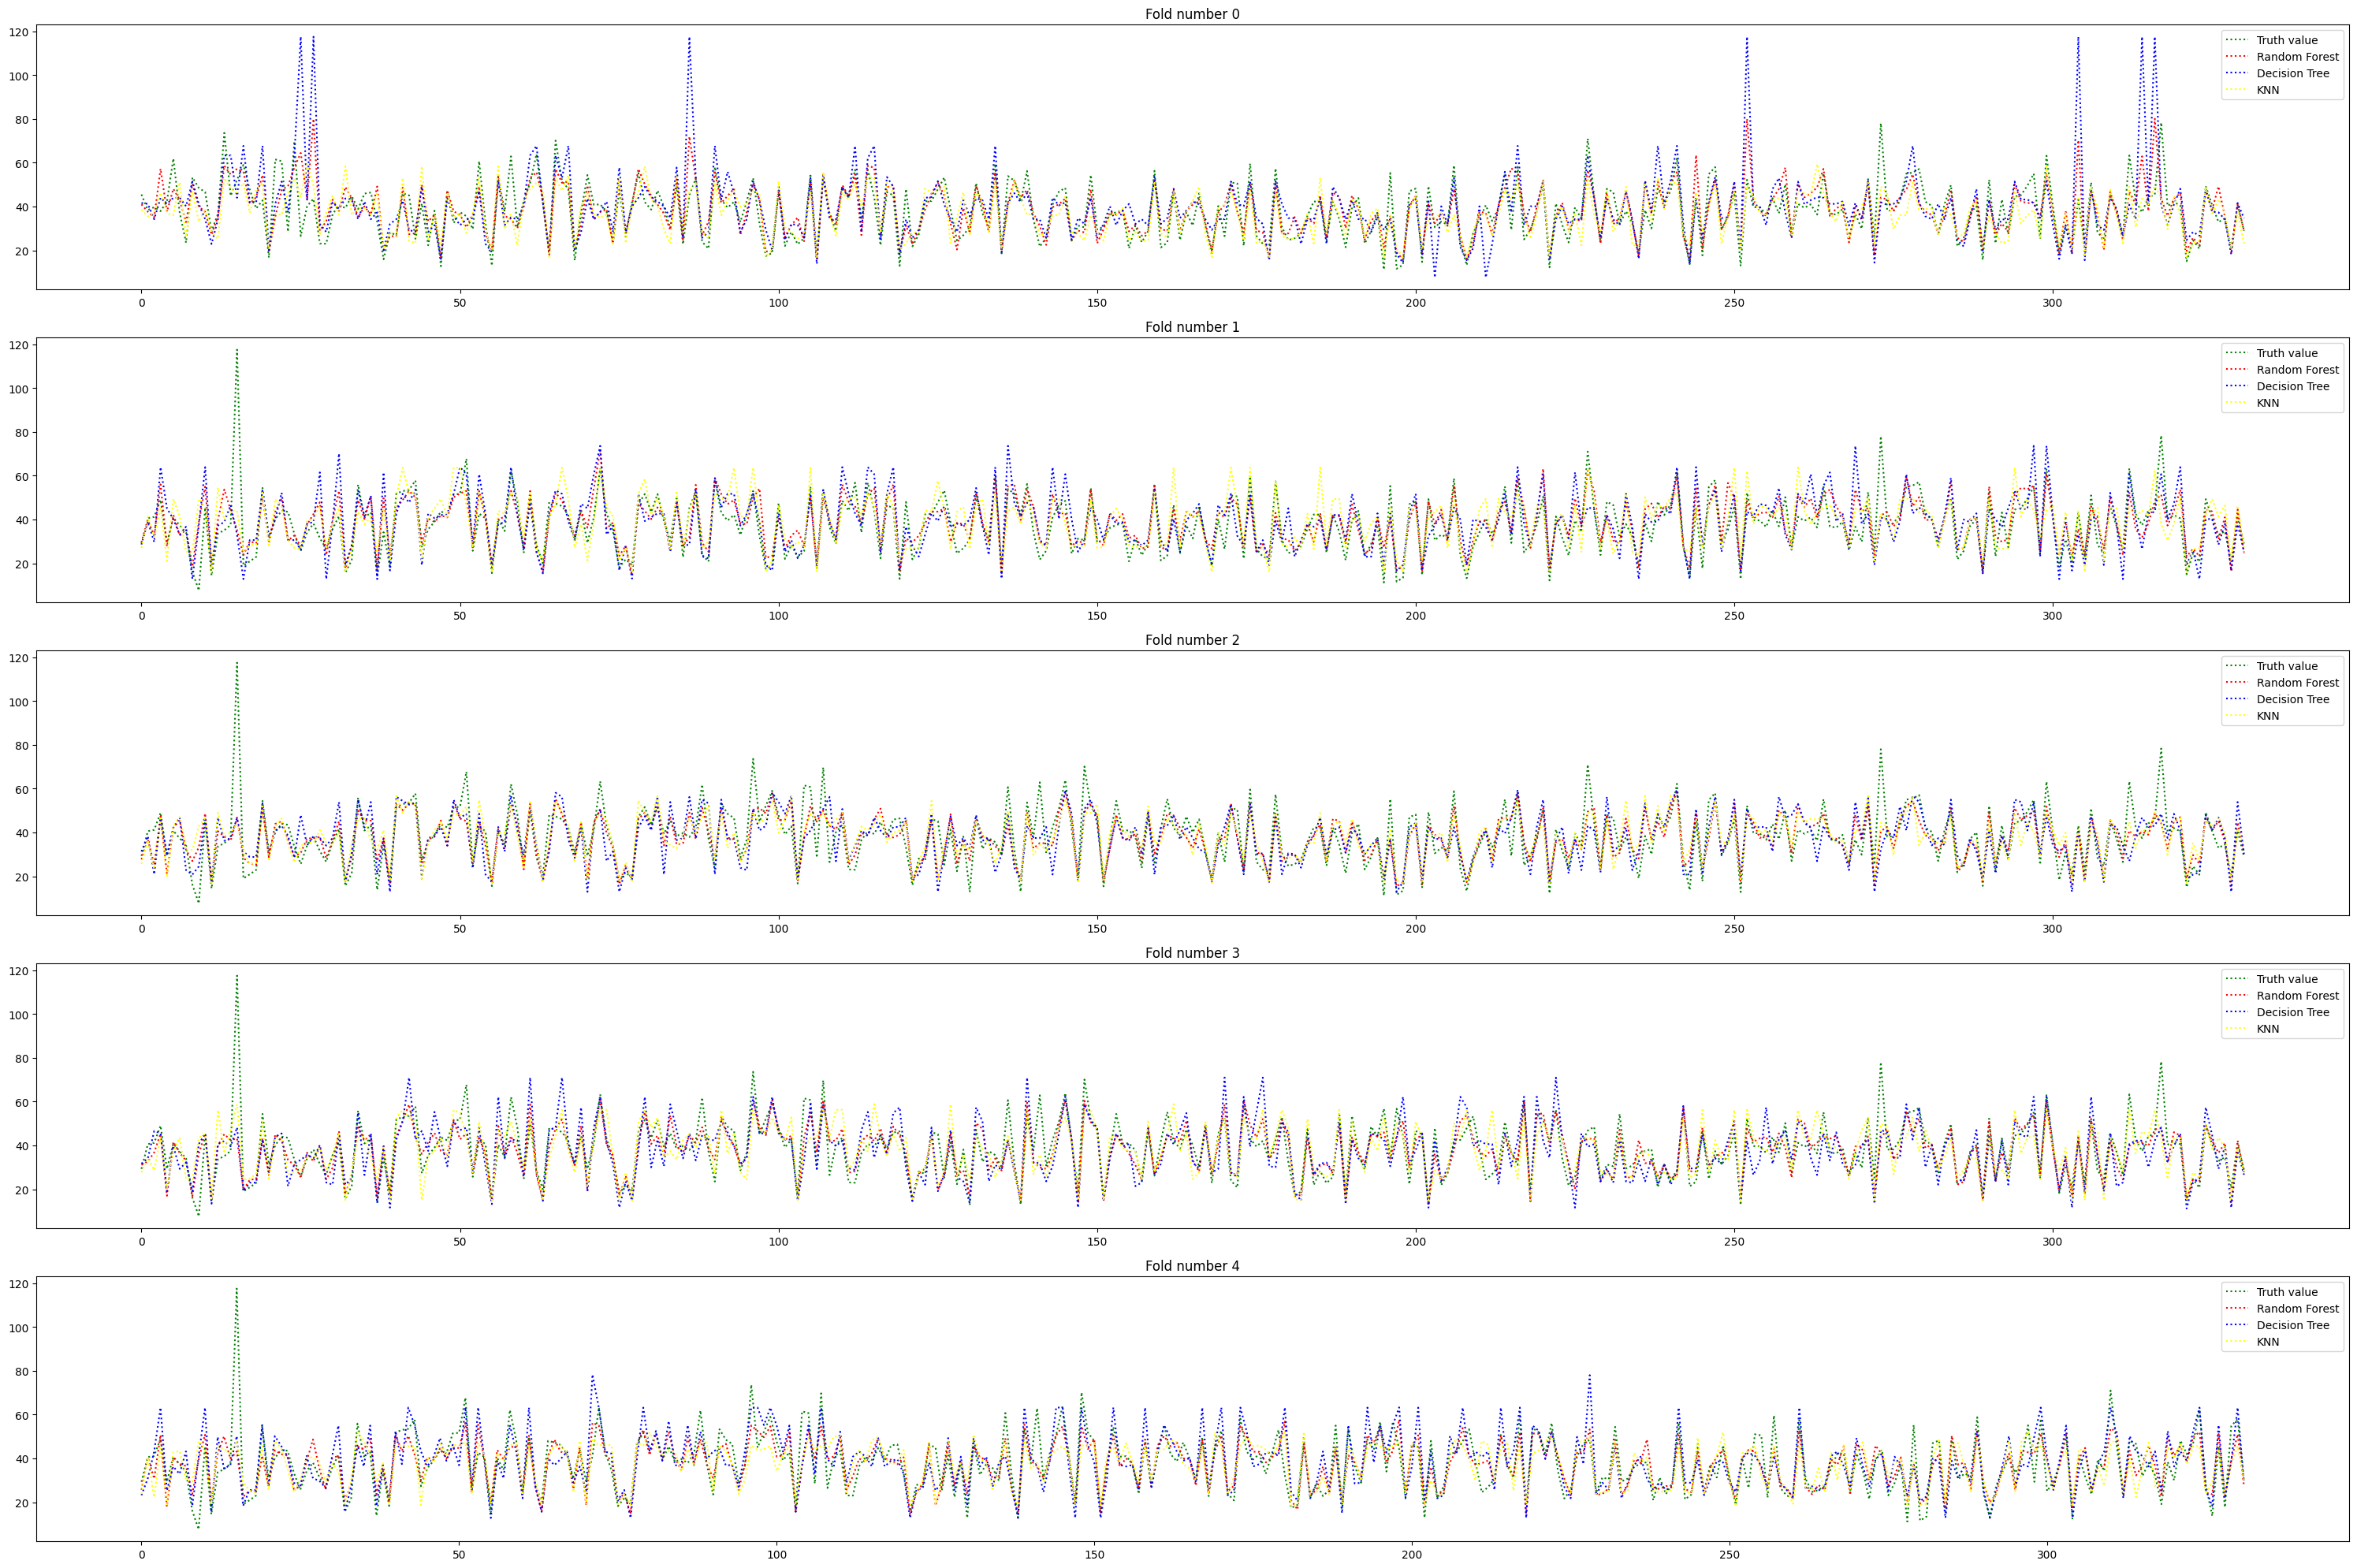

In [168]:
#Execution cell
models = [rf_g, dt_g, knn_g]
truth_val_tests, model_predictions_tuples = cross_validate(models,data,5)

plot_cv_results(truth_val_tests, model_predictions_tuples)


In [16]:
def obsolete_cross_validate(model, dataset ,fold_number = 5) :
    #--Declare function variables
    division_accuracy = list()
    accuracy_of_folds = []
    f1_score_of_folds = []

    #--Get array of folds as dataframe
    folds = slide_df_to_n_folds (dataset, fold_number)

    #Loop through each fold as the testing fold and training the other fold. The purpose is to calculate the
    #accuracy score.
    for i in range(0,len(folds)):
        print(f"\n---------------Test fold on fold number: {i} --------------\n")
        #--Print testing data
        print(f"----The Testing fold is: \n{folds[i]}")

        #--Groups fold !=fold[i] into training fold
        training_data = pd.DataFrame()

        for j in range(0,len(folds)):
            if j != i:
                training_data = pd.concat([training_data, folds[j]], axis=0)

        print(f"\n--The Training fold of testing fold number {i} is: \n{training_data}")
        #--Train model on training fold
        model.fit(training_data.drop(columns='target'), training_data.target)
        #--Make prediction
        prediction_result = model.predict(folds[i].drop(columns='target'))

        #--Calculate the accuracy score
        accuracy = accuracy_score(folds[i].target, prediction_result)
        accuracy_of_folds.append(round(accuracy,4))

        #--Calculate the f1 score
        f1score = f1_score(folds[i].target, prediction_result,average='macro')
        f1_score_of_folds.append(round(f1score.item(),4))

    #--Calculate average accuracy
    avarage_accuracy = round(sum(accuracy_of_folds)/fold_number,4)

    #Calculate the standard deviation
    standard_deviation_accuracy = round(statistics.stdev(accuracy_of_folds),4)

    return accuracy_of_folds, avarage_accuracy, standard_deviation_accuracy, f1_score_of_folds

cross_validate(knn, iris_df)



---------------Test fold on fold number: 0 --------------

----The Testing fold is: 
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
57                 4.9               2.4                3.3               1.0   
112                6.8               3.0                5.5               2.1   
125                7.2               3.2                6.0               1.8   
64                 5.6               2.9                3.6               1.3   
71                 6.1               2.8                4.0               1.3   
17                 5.1               3.5                1.4               0.3   
109                7.2               3.6                6.1               2.5   
68                 6.2               2.2                4.5               1.5   
127                6.1               3.0                4.9               1.8   
5                  5.4               3.9                1.7               0.4   
85                 6.0 

([0.9333, 0.9667, 0.9667, 0.9667, 0.9667],
 0.96,
 0.0149,
 [0.9302, 0.968, 0.9696, 0.9515, 0.9582])

In [26]:
def cal_f1_score(model, dataset): 
    #--Train model on training fold
    model.fit(dataset.drop(columns='target'), dataset.target)
    
    #--Make prediction
    prediction_result = model.predict(dataset.drop(columns='target'))
    
    f1score = f1_score(dataset.target, prediction_result,average='macro')
    
    return round(f1score,4)

np.float64(0.9667)

In [17]:
def save_crvInfo_to_xlsx (workbook, worksheet_name, accuracies, average_accuracies, standard_deviation_accuracy, f1_score_of_folds):
    
    worksheet_fold = workbook.add_worksheet(worksheet_name)
    
    worksheet_fold.write(0, 0, f"Fold number")
    worksheet_fold.write(0, 1, f"Accuracy number")
    
    row = 1
    
    for m in range(len(accuracies)): 
        worksheet_fold.write(row, 0, f"{m}")
        worksheet_fold.write(row, 1, f"{accuracies[m]}")
        row += 1
    
    worksheet_fold.write(row, 0, f"Average Accuracy: {average_accuracies}")
    row += 1
    worksheet_fold.write(row, 0, f"Standard Derivation: {standard_deviation_accuracy}")
    row += 1
    
    row += 3
    
    worksheet_fold.write(row, 0, f"Fold number")
    worksheet_fold.write(row, 1, f"F1 Score number")
    
    row += 1
    
    for k in range(len(accuracies)): 
        worksheet_fold.write(row, 0, f"{k}")
        worksheet_fold.write(row, 1, f"{f1_score_of_folds[k]}")
        row += 1

In [18]:
#Exucution cell
workbook = xlsxwriter.Workbook("Result.xlsx")

tuple = cross_validate(knn, iris_df, 5)
save_crvInfo_to_xlsx(workbook, "KNN", *tuple)

tuple = cross_validate(dtree_entropy, iris_df, 5)
save_crvInfo_to_xlsx(workbook, "Entropy Decision Tree", *tuple)

tuple = cross_validate(knn_weight, iris_df, 5)
save_crvInfo_to_xlsx(workbook, "KNN with weights", *tuple)

tuple = cross_validate(dtree_gini, iris_df, 5)
save_crvInfo_to_xlsx(workbook, "Ghini Decision Tree", *tuple)

workbook.close()


---------------Test fold on fold number: 0 --------------

----The Testing fold is: 
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
7                  5.0               3.4                1.5               0.2   
105                7.6               3.0                6.6               2.1   
24                 4.8               3.4                1.9               0.2   
116                6.5               3.0                5.5               1.8   
23                 5.1               3.3                1.7               0.5   
80                 5.5               2.4                3.8               1.1   
41                 4.5               2.3                1.3               0.3   
6                  4.6               3.4                1.4               0.3   
57                 4.9               2.4                3.3               1.0   
139                6.9               3.1                5.4               2.1   
69                 5.6 

In [ ]:
# for i in range(0,len(division_accuracy), 5):
#     fold_number = int(i/int(len(division_accuracy)/5))
#     temp_array = division_accuracy[i:i+5]
#     a = np.asarray(temp_array)
#     np.savetxt(f"fold{fold_number}result.csv", a, fmt="%.3f", delimiter=",")